# Проект №3 EDA + Feature Engineering Booking.com

### Какой кейс решаем?
Представим, что работаем дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

### Наименование столбцов:

* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

### Файлы для соревнования

* hotels_train.csv - набор данных для обучения [источник данных](https://github.com/slagovskiy/DST/raw/main/Project-3/data/hotels_train.csv.zip)
* hotels_test.csv - набор данных для оценки качества [источник данных](https://github.com/slagovskiy/DST/raw/main/Project-3/data/hotels_train.csv.zip)
* submission.csv - файл сабмишна в нужном формате [источник данных](https://github.com/slagovskiy/DST/raw/main/Project-3/data/hotels_train.csv.zip)


---

## 0. Исходные данные

### Библиотеки

In [9]:
import pandas as pd
import numpy as np
from collections import Counter
from category_encoders import TargetEncoder
from sklearn import preprocessing
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/anatolijnalivajko/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Константы

In [10]:
RANDOM_SEED = 42  # всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
TARGET = 'reviewer_score'

### Данные

In [11]:
#Для работы на Kaggle
#DATA_DIR = '/kaggle/input/sf-booking/'
#df_train = pd.read_csv(DATA_DIR + 'hotels_train.csv')
#df_test = pd.read_csv(DATA_DIR + 'hotels_test.csv')
#sample_submission = pd.read_csv(DATA_DIR + 'submission.csv')

# Для работы в Jupyter Notebook Visual Studio Code
DATA_DIR = 'data_kaggle'
df_train = pd.read_csv(DATA_DIR + '/hotels_train.csv')
df_test = pd.read_csv(DATA_DIR + '/hotels_test.csv')
sample_submission = pd.read_csv(DATA_DIR + '/submission.csv')

---

## 1. Предварительная обработка данных

### 1.1. Первичная очистка

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

**Стандартный отчет, созданный с помощью библиотеки Pandas Profiling, использовался для оценки исходных дистрибутивов и общих параметров функций..**

In [13]:
dupl_percent = df_train.duplicated().mean() * 100
print(f'Дублированные строки в образце: {dupl_percent:.2f}%')
df_train.drop_duplicates(inplace=True)
print('Дубликаты удалены')

Дублированные строки в образце: 0.08%
Дубликаты удалены


In [14]:
df_train.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [15]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [16]:
df_test.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520


In [17]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [18]:
sample_submission.head()

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


In [19]:
df_train['sample'] = 1
df_test['sample'] = 0
df_test['reviewer_score'] = 0

hotels = pd.concat([df_train, df_test], sort=False).reset_index(drop=True)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [20]:
print('Количество пробелов в столбцах типа object')
for col in hotels.dtypes[hotels.dtypes=='object'].index:
    print(col+':', hotels[hotels[col] == ' '].shape[0])

Количество пробелов в столбцах типа object
hotel_address: 0
review_date: 0
hotel_name: 0
reviewer_nationality: 523
negative_review: 849
positive_review: 183
tags: 0
days_since_review: 0


In [21]:
# Здесь мы заполняем пробелы в столбце «reviewer_nationality» 
# «negative_review» и «positive_review»  
# поскольку столбцы 'lat и 'lng' со значениями NaN должны быть обработаны позже.

hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(
    lambda x: x[1:-1])  # Удаление пробелов вокруг: ' Spain ' -> 'Spain'
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x[1:-1]) 
hotels['positive_review'] = hotels['positive_review'].apply(
    lambda x: x[1:-1])

replace_dict1 = {'': hotels['reviewer_nationality'].mode()[0]}
replace_dict2 = {'': hotels['negative_review'].mode()[0]}
replace_dict3 = {'': hotels['positive_review'].mode()[0]}

hotels['reviewer_nationality'].replace(replace_dict1, inplace=True)
hotels['negative_review'].replace(replace_dict2, inplace=True)
hotels['positive_review'].replace(replace_dict3, inplace=True)

### 1.2. Разработка функций

In [22]:
# Извлечение названий стран и почтовых индексов из адресов гостиниц. Есть только
# один город на страну в адресах, поэтому мы опускаем извлечение названия города как
# это не даст никакой новой информации для алгоритмов ML, и в этом
# частный случай "город == страна". Почтовый индекс, с другой стороны, содержит
# информация о расположении отеля в городе, что может быть очень
# полезно для оценки рейтинга

def address_proc(x):
    words = x.split()
    country = words[-1]
    if country=='Kingdom' or country=='Netherlands':
        zip_code = words[-4] + words[-3]
    else:
        zip_code = words[-3]
    return pd.Series([country, zip_code])


hotels[['hotel_country', 'zip_code']] = hotels['hotel_address'].apply(address_proc)
hotels['hotel_country'].replace({'Kingdom': 'United Kingdom'}, inplace=True)

print('Страны:', hotels['hotel_country'].unique())
print('Количество почтовых индексов (районов города):', hotels['zip_code'].nunique())

Страны: ['United Kingdom' 'France' 'Netherlands' 'Italy' 'Austria' 'Spain']
Количество почтовых индексов (районов города): 601


In [23]:
# Кодирование столбцов с высокой кардинальностью с помощью Target Encoder

cols = ['hotel_name', 'reviewer_nationality', 'zip_code']
target_encoder = TargetEncoder(cols=cols)
hotels_encoded = target_encoder.fit_transform(
    hotels[cols], hotels[TARGET])

rename_dict = {
    'hotel_name': 'hotel_name_enc', 
    'reviewer_nationality': 'reviewer_nationality_enc', 
    'zip_code': 'zip_code_enc'
}
hotels_encoded.rename(columns=rename_dict, inplace=True)
hotels = pd.concat([hotels, hotels_encoded], axis=1)

In [24]:
# Проверка NaN в закодированных функциях

print(hotels['hotel_name_enc'].isnull().mean())
print(hotels['reviewer_nationality_enc'].isnull().mean())
print(hotels['zip_code_enc'].isnull().mean())

0.0
0.0
0.0


In [25]:
# Внутренний клиент: национальность рецензента и страна отеля одинаковы.
hotels['domestic_customer'] = hotels.apply(lambda x:
    1 if x['hotel_country'] == x['reviewer_nationality'] else 0, axis=1)    

In [26]:
# Извлечение некоторой информации из даты проверки.
#
# День года кодируется синусом и косинусом, чтобы отразить цикличность
# процесс. Одновременно с числовым описанием календарной даты
# позволяет нам кодировать смену времен года более точным способом.
# Индикаторы Рождества и выходных дней дополнительно включено.

hotels['review_date'] = pd.to_datetime(hotels['review_date'])

hotels['sin_date'] = np.sin(2 * np.pi * hotels['review_date'].dt.dayofyear / 365)
hotels['cos_date'] = np.cos(2 * np.pi * hotels['review_date'].dt.dayofyear / 365)

hotels['christmas'] = hotels['review_date'].apply(lambda x: 
    1 if (x.month==12 and x.day>=25) or (x.month==1 and x.day<=5) else 0)
hotels['weekend'] = hotels['review_date'].apply(lambda x: 
    1 if x.dayofweek==5 or x.dayofweek==6 else 0)

In [27]:
# Анализ настроений
#
# Сначала делаем пустые строки для различных обозначений пустых отзывов,
# затем проанализируем негативные и позитивные отзывы отдельно с помощью VADER
# анализа тональности и получение в результате «составного» значения.

replace_dict_negative = {
    'No Negative': '',
    ' Nothing ': '',
    ' Nothing': '',
    ' nothing ': '',
    ' nothing': '',
    ' N A ': '',
    ' N A': '',
    ' N a ': '',
    ' N a': '',
    ' None ': '',
    ' None': '',
    ' ': ''   
}

replace_dict_positive = {
    'No Positive': '',
    ' Nothing ': '',
    ' Nothing': '',
    ' nothing ': '',
    ' nothing': '',
    ' N A ': '',
    ' N A': '',
    ' N a ': '',
    ' N a': '',
    ' None ': '',
    ' None': '',
    ' ': ''   
}

hotels['negative_review'].replace(replace_dict_negative, inplace=True)
hotels['positive_review'].replace(replace_dict_positive, inplace=True)

mask = hotels['negative_review'] == ''
hotels.loc[mask, 'review_total_negative_word_counts'] = 0

mask = hotels['positive_review'] == ''
hotels.loc[mask, 'review_total_positive_word_counts'] = 0

analyzer = SentimentIntensityAnalyzer()
hotels['n_sentiment'] = hotels['negative_review'].apply(lambda x: 
    analyzer.polarity_scores(x)['compound'])
hotels['p_sentiment'] = hotels['positive_review'].apply(lambda x: 
    analyzer.polarity_scores(x)['compound'])

In [28]:
# Теги. Преобразование строковых переменных в списки.

hotels['tags'] = hotels['tags'].apply(lambda x: x[3:-3].split(' \', \' '))

In [29]:
# Получение продолжительности пребывания.
# Заполнение значений NaN типичной продолжительностью пребывания: 1 день.

def get_stay(x):
    for tag in x:
        words = tag.split()
        if words[0] =='Stayed':
            return int(words[1])
    return np.NaN

hotels['stay'] = hotels['tags'].apply(get_stay)
hotels['stay'].fillna(1, inplace=True)

In [30]:
# Запускаем кодирование для наиболее частых тегов. Граница для
# наиболее часто берется 5% от размера набора данных.

boundary = hotels.shape[0] * 0.05  # 5% граница
c = Counter(tag for row in hotels['tags'] for tag in row)
frequent_tags_count = dict(filter(lambda x: x[1] > boundary, c.items()))
print('Наиболее часто встречающиеся теги и их количество:')
frequent_tags_count

Наиболее часто встречающиеся теги и их количество:


{'Leisure trip': 417538,
 'Couple': 252128,
 'Stayed 2 nights': 133850,
 'Submitted from a mobile device': 307470,
 'Business trip': 82884,
 'Standard Double Room': 32247,
 'Stayed 1 night': 193568,
 'Solo traveler': 108476,
 'Stayed 3 nights': 95761,
 'Superior Double Room': 31361,
 'Stayed 4 nights': 47777,
 'Double Room': 35207,
 'Family with young children': 60989,
 'Group': 65361,
 'Family with older children': 26334}

In [31]:
# Получение списка наиболее часто встречающихся тегов. Теги "stay" исключены

frequent_tags = list(dict(filter(lambda x: 
    x[1]>boundary and x[0].split()[0]!='Stayed', 
    frequent_tags_count.items())).keys())
frequent_tags

['Leisure trip',
 'Couple',
 'Submitted from a mobile device',
 'Business trip',
 'Standard Double Room',
 'Solo traveler',
 'Superior Double Room',
 'Double Room',
 'Family with young children',
 'Group',
 'Family with older children']

In [32]:
# Быстрое кодирование для частых тегов.

for tag in frequent_tags:
    hotels[tag] = hotels['tags'].apply(lambda x: 1 if tag in x else 0)

In [33]:
# Преобразование функции «days_since_review» в хронологический порядок
# даты проверки: с 0 дня до последнего дня.

hotels['days_since_review'] \
    = hotels['days_since_review'].apply(lambda x: int(x.split()[0]))
hotels['day_number'] \
    = (hotels['days_since_review']-hotels['days_since_review'].max()) * (-1)

In [34]:
# Заполнение значений NaN широты и долготы средними значениями
# для каждого почтового индекса (района города).

# Фрейм данных со средними значениями:
zip_medians = hotels.groupby('zip_code')[['lat', 'lng']].median()

mask1 = hotels['lat'].isnull()
zip_nulls = hotels[mask]['zip_code'].unique()  # почтовые индексы с NaN lat и lng
for zip_code in zip_nulls:
    mask2 = hotels['zip_code'] == zip_code
    hotels.loc[mask1 & mask2, 'lat'] = zip_medians.loc[zip_code, 'lat']
    hotels.loc[mask1 & mask2, 'lng'] = zip_medians.loc[zip_code, 'lng']
# Дозаполним то для чего не нашлось почтового индекса средним значением
hotels['lat'] = hotels['lat'].fillna(hotels['lat'].median())
hotels['lng'] = hotels['lng'].fillna(hotels['lat'].median())

In [35]:
print('Доля NaN осталась')
print('lat:', hotels['lat'].isnull().mean())
print('lng:', hotels['lng'].isnull().mean())

Доля NaN осталась
lat: 0.0
lng: 0.0


In [36]:
# Получение расстояния от центра города

for country in hotels['hotel_country'].unique():
    
    mask = hotels['hotel_country']==country
    
    # Городские центры как медианные значения для страны (=город)
    lat_median = hotels[mask]['lat'].median()
    lng_median = hotels[mask]['lng'].median()
    
    hotels.loc[mask, 'distance'] = ((hotels[mask]['lat']-lat_median)**2
                                  +(hotels[mask]['lng']-lng_median)**2) ** (1/2)
# Дозаполним пропуски средним значением
hotels['distance'] = hotels['distance'].fillna(hotels['distance'].median())
print('Доля NaN осталась')
print('distance:', hotels['distance'].isnull().mean())
    

Доля NaN осталась
distance: 0.0


In [37]:
# Быстрое кодирование стран/городов отелей.

country_onehot = pd.get_dummies(hotels['hotel_country'])
hotels = pd.concat([hotels, country_onehot], axis=1)

In [38]:
# Удаление обработанных столбцов

hotels.drop(['hotel_address', 'review_date', 'hotel_name', 'zip_code',
           'reviewer_nationality', 'negative_review', 'positive_review',
           'tags', 'days_since_review', 'lat', 'lng', 'hotel_country'], 
          axis=1, inplace=True)

### 1.3. Мультиколлинеарность

In [39]:
def get_correlated(corr_matrix, thres=0.7):
    """Getting correlated pairs from a correlation matrix 
       with correlation coefficients higher than the threshold

    Args:
        corr_matrix (pandas DataFrame): correlation matrix (e.g., from df.corr())
        thres (float, optional): threshold. Defaults to 0.7 (i.e., coeff > 0.7 or coeff < -0.7).

    Returns:
        pandas Series: correlated pairs and correlation coefficients
    """
    
    correlated_pairs = {}
    
    for col in corr_matrix.columns:
        positive_filter = corr_matrix[col] >= thres
        negative_filter = corr_matrix[col] <= -thres
        match_series = corr_matrix[col][positive_filter | negative_filter]
        for match in match_series.index:
            if match != col and match + ' -- ' + col not in correlated_pairs.keys():
                correlated_pairs.update({col + ' -- ' + match: match_series[match]})
   
    return pd.Series(correlated_pairs).sort_values()


print('Коррелированные пары:')
get_correlated(hotels.corr(method='spearman'))

Коррелированные пары:


Leisure trip -- Business trip                             -0.904047
review_total_positive_word_counts -- p_sentiment           0.737386
reviewer_score -- sample                                   0.758933
average_score -- zip_code_enc                              0.796794
hotel_name_enc -- zip_code_enc                             0.828320
additional_number_of_scoring -- total_number_of_reviews    0.859098
average_score -- hotel_name_enc                            0.892666
dtype: float64

In [40]:
# Отбрасывание совпадений с сильной корреляцией. Мы оставим
# пару "review_total_positive_word_counts - p_sentiment", как корреляция
# не так уж силен, и если оставить обе функции, MAPE немного улучшится.

hotels.drop([
    'Business trip', 'additional_number_of_scoring', 
    'hotel_name_enc', 'zip_code_enc'], 
    axis=1, inplace=True)

### 1.4. Нормализация

In [41]:
# После анализа дистрибутивов (методом Pandas df.hist()),
# были выбраны следующие скейлеры:
# 
# MinMaxScaler - for 'average_score', 'day_number'
#
# RobustScaler - for 'review_total_negative_word_counts', 
# 'review_total_positive_word_counts', 'total_number_of_reviews', 
# 'total_number_of_reviews_reviewer_has_given', 
# 'reviewer_country_population'
#
# Other columns - without normalization

cols_minmax = ['average_score', 'day_number']
cols_robust = [
    'review_total_negative_word_counts', 'review_total_positive_word_counts',
    'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given']

mm_scaler = preprocessing.MinMaxScaler()
r_scaler = preprocessing.RobustScaler()

hotels_mm = mm_scaler.fit_transform(hotels[cols_minmax])
hotels_mm = pd.DataFrame(hotels_mm, columns=cols_minmax)

hotels_rs = r_scaler.fit_transform(hotels[cols_robust])
hotels_rs = pd.DataFrame(hotels_rs, columns=cols_robust)

hotels[cols_minmax] = hotels_mm[cols_minmax]
hotels[cols_robust] = hotels_rs[cols_robust]

### 1.5. Выбор признаков

In [42]:
# X — Признаки, y — цель

X = hotels.drop([TARGET], axis = 1)  
y = hotels[TARGET]

In [43]:
# Категория и непрерывные признаки

cat_cols = [
    'domestic_customer', 'christmas', 'weekend', 'Leisure trip', 'Couple', 
    'Submitted from a mobile device', 'Standard Double Room', 'Solo traveler', 
    'Superior Double Room', 'Double Room', 'Family with young children', 
    'Group', 'Family with older children', 'Austria', 'France', 'Italy',
    'Netherlands', 'Spain', 'United Kingdom', 'stay']

cont_cols = [
    'average_score', 'review_total_negative_word_counts', 'distance',
    'total_number_of_reviews', 'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given', 'reviewer_nationality_enc', 
    'sin_date', 'cos_date', 'n_sentiment', 
    'p_sentiment', 'day_number']

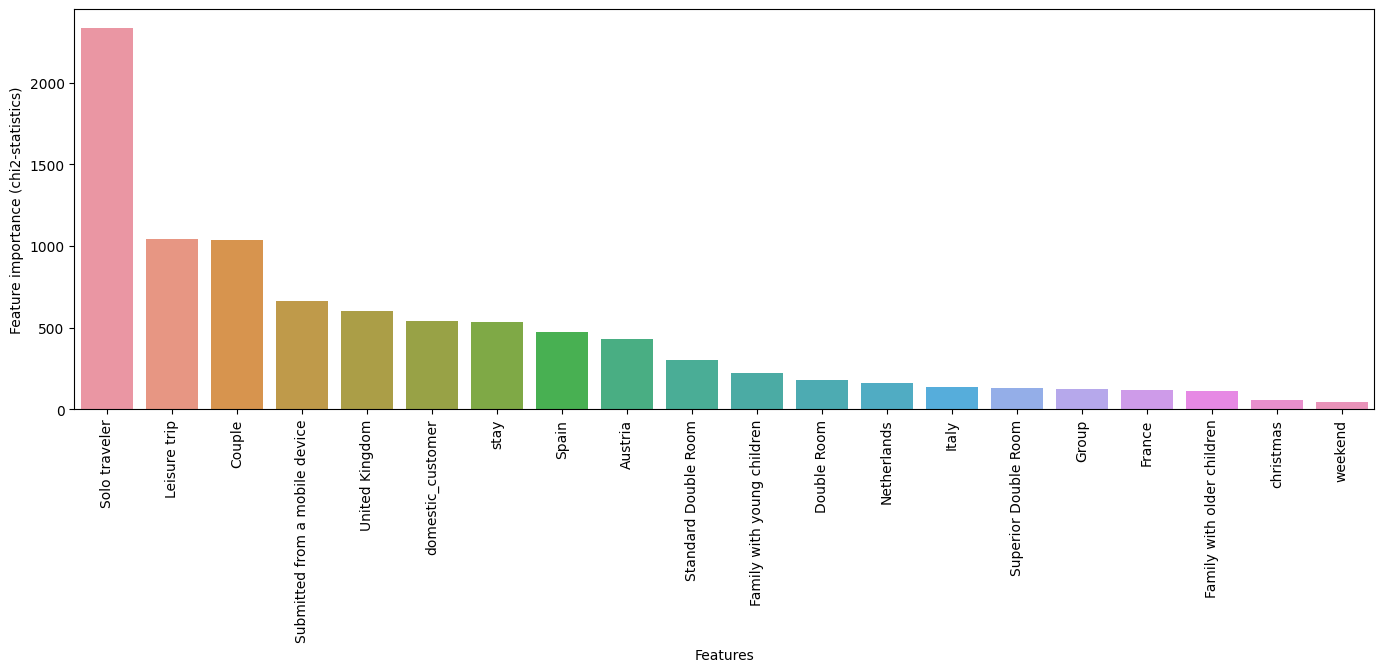

In [44]:
# Расчет chi2-статистики для категориальных признаков

y_cat = (y * 10).astype('int')  # класс не может быть плавающим для chi2

chi2_stat, chi2_p = chi2(X[cat_cols], y_cat)
chi2_stat = pd.DataFrame(chi2_stat, index=cat_cols).reset_index()
chi2_stat.rename(
    columns={'index': 'Features', 0: 'Feature importance (chi2-statistics)'}, 
    inplace=True)
chi2_stat['p-value'] = chi2_p
chi2_stat.sort_values('Feature importance (chi2-statistics)', 
                   inplace = True, ascending=False)

fig = plt.figure(figsize=(13, 4))
ax = fig.add_axes([1, 1, 1, 1])
plt.xticks(rotation=90)
sns.barplot(data=chi2_stat, x='Features', y='Feature importance (chi2-statistics)');

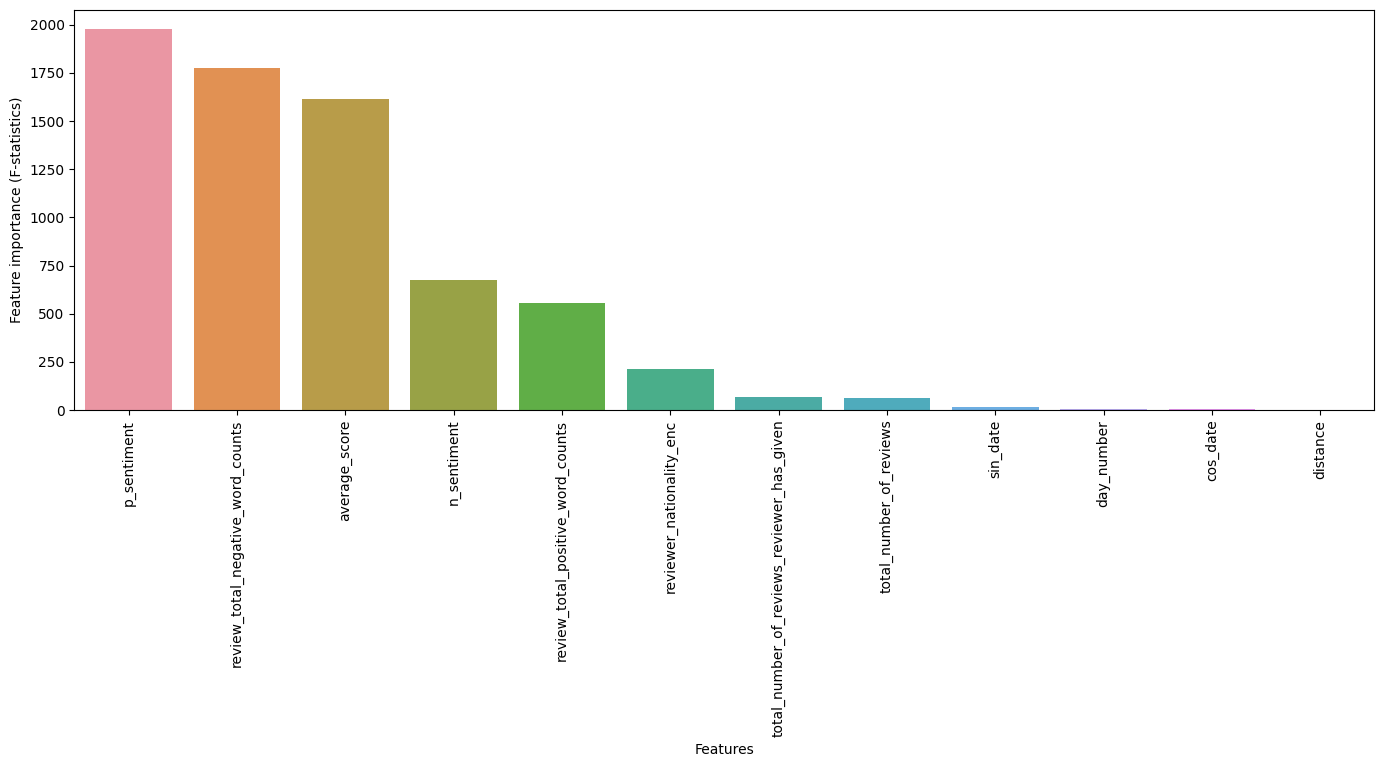

In [45]:
# Расчет F-статистики (ANOVA) для категориальных признаков

f_stat, f_p = f_classif(X[cont_cols], y)
f_stat = pd.DataFrame(f_stat, index=cont_cols).reset_index()
f_stat.rename(
    columns={'index': 'Features', 0: 'Feature importance (F-statistics)'}, 
    inplace=True)
f_stat['p-value'] = f_p
f_stat.sort_values('Feature importance (F-statistics)', 
                   inplace = True, ascending=False)

fig = plt.figure(figsize=(13, 4))
ax = fig.add_axes([1, 1, 1, 1])
plt.xticks(rotation=90)
sns.barplot(data=f_stat, x='Features', y='Feature importance (F-statistics)');

In [46]:
# Кроме того, давайте проверим значимость, используя p-value

mask = chi2_stat['p-value'] > 0.05  # 5% граница
print('Незначительная категория включает в себя:', 
      list(chi2_stat[mask]['Features']))

mask = f_stat['p-value'] > 0.05  # 5% граница
print('Незначительные непрерывные признаки:', 
      list(f_stat[mask]['Features']))

Незначительная категория включает в себя: ['weekend']
Незначительные непрерывные признаки: ['distance']


In [47]:
# Отбрасывание несущественных признаков
# Оставим 'distance' Это улучшает MAPE

drop_cols = ['weekend']
hotels.drop(drop_cols, axis=1, inplace = True)

## 3. Обучение модели и получение предсказания

In [48]:
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 32), (386496, 32), (386496, 31), (309196, 31), (77300, 31))

In [49]:
model = RandomForestRegressor(
    n_estimators=100,
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_SEED)

In [50]:
%%time

# обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s


CPU times: user 12min 50s, sys: 17 s, total: 13min 7s
Wall time: 4min 39s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    6.1s finished


In [51]:
def mean_absolute_percentage_error(y_tr, y_pr):
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

print('MAPE:', round(mean_absolute_percentage_error(y_test, y_pred), 2))

MAPE: 12.57


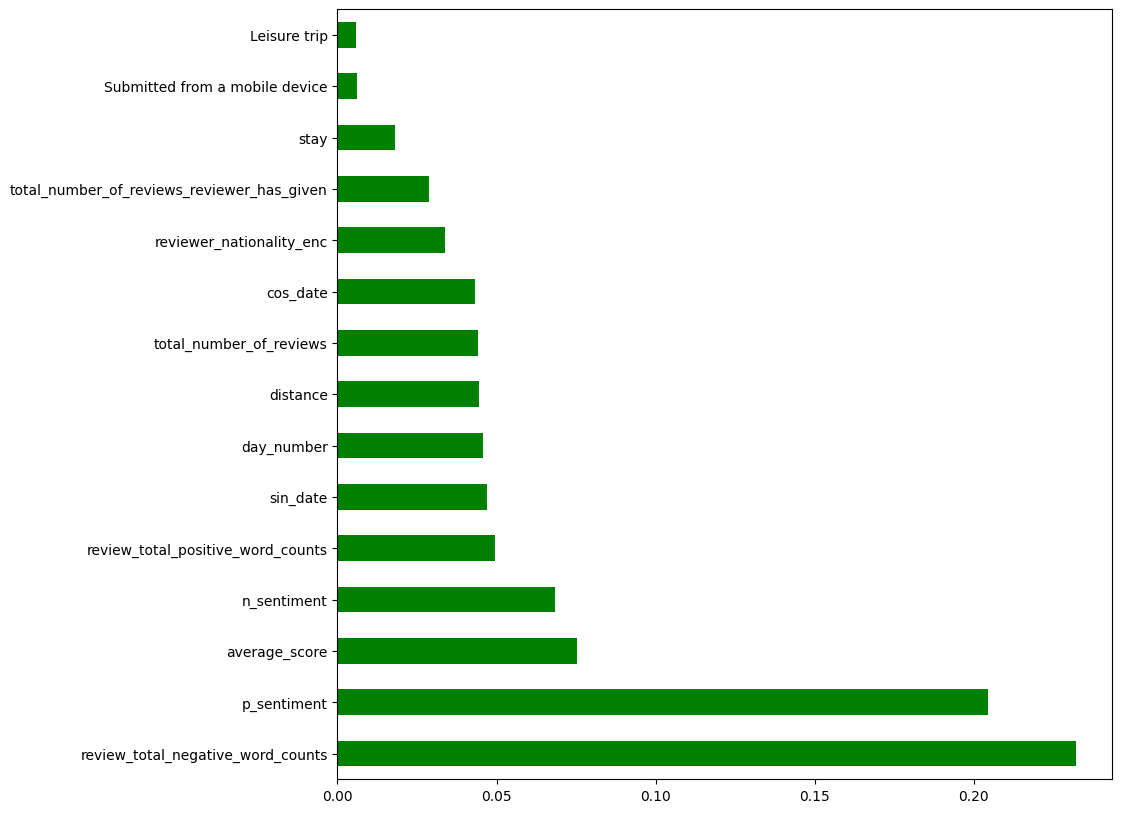

In [52]:
# Особенности важности

plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh', color='green');

In [53]:
test_data = test_data.drop(['reviewer_score'], axis=1)
predict_submission = model.predict(test_data)
sample_submission['reviewer_score'] = predict_submission

#  сохраняем результат:
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.1s finished


,reviewer_score,id
0,8.821,488440
1,7.637,274649
2,8.310,374688
3,9.490,404352
4,9.526,451596
5,9.133,302161
6,8.183,317079
7,7.553,13963
8,8.505,159785
9,7.619,195089


In [54]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt